In [14]:
# -- IMPORTS START --
import pandas as pd
import glob
import re
import os
import sys
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
# -- IMPORTS END --

# enable zooming into graphs
%matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 6] # width, height in inches

In [15]:
def viz_tree(dt_model,features_frames,cnames):
    # Fix feature names as list
    feature_names = features_frames.columns.tolist()

    fig, ax = plt.subplots(figsize=(9,4))
    tree.plot_tree(dt_model,  
                   feature_names=feature_names,
                   fontsize=7,
                   class_names=cnames,
                   filled=True,
                   ax=ax)

    plt.title('Decision Tree')

Calculates magnitude of acceleration and rotational rate

In [16]:
def calc_magnitude(data):

    required_columns = ['accelerationX', 'accelerationY', 'accelerationZ']
    if all(col in data.columns for col in required_columns):
        data['accel_mag'] = np.sqrt(data['accelerationX']**2 + data['accelerationY']**2 + data['accelerationZ']**2)
        data['accel_mag'] = data['accel_mag'] - data['accel_mag'].mean()
    else:
        raise KeyError(f"Missing required columns: {required_columns}")
    return data


In [17]:
def rotation_magnitude(data):
    
    required_columns = ['rotationRateX', 'rotationRateY', 'rotationRateZ']
    if all(col in data.columns for col in required_columns):
        data['rotation_mag'] = np.sqrt(data['rotationRateX']**2 + data['rotationRateY']**2 + data['rotationRateZ']**2)
        data['rotation_mag'] = data['rotation_mag'] - data['rotation_mag'].mean()
    else:
        raise KeyError(f"Missing required columns: {required_columns}")
    return data


Remove Noise from both Acceration and Rotation

In [18]:
def remove_noise(data,sampling_rate):
    from scipy.signal import butter, filtfilt, find_peaks

    # Low pass filter
    cutoff = 5 # Hz
    order = 2
    b, a = butter(order, cutoff/(sampling_rate/2), btype='lowpass')
    data['filtered_accel_mag'] = filtfilt(b, a, data['accel_mag'])

    return data

In [19]:
def remove_noise_rotation(data,sampling_rate):
    from scipy.signal import butter, filtfilt, find_peaks

    # Low pass filter
    cutoff = 5 # Hz
    order = 2
    b, a = butter(order, cutoff/(sampling_rate/2), btype='lowpass')
    data['filtered_rotation_mag'] = filtfilt(b, a, data['rotation_mag'])

    return data


Adding features per window with both acceleration and rotation

In [28]:

def add_features(window):
    features = {}
    # A = acceleration
    features['Aavg'] = window['filtered_accel_mag'].mean()
    features['Amed'] = window['filtered_accel_mag'].quantile(0.5)
    features['Aq25'] = window['filtered_accel_mag'].quantile(0.25)
    features['Aq75'] = window['filtered_accel_mag'].quantile(0.75)
    features['Astd'] = window['filtered_accel_mag'].std()
    # R = rotation
    features['Ravg'] = window['filtered_rotation_mag'].mean()
    features['Rmed'] = window['filtered_rotation_mag'].quantile(0.5)
    features['Rq25'] = window['filtered_rotation_mag'].quantile(0.25)
    features['Rq75'] = window['filtered_rotation_mag'].quantile(0.75)
    features['Rstd'] = window['filtered_rotation_mag'].std()
    df = pd.DataFrame()
    df = df._append(features,ignore_index=True)
    return df

In [29]:
def extract_features_sliding_window(data, window_sec, step_sec, sample_rate, activity):
    features_list = []
    num_samples = len(data)
    window_samples = int(window_sec * sample_rate)
    step_samples = int(step_sec * sample_rate)

    for start in range(0, num_samples - window_samples + 1, step_samples):
        end = start + window_samples
        window = data.iloc[start:end]
        features = add_features(window)
        features['activity'] = activity
        features_list.append(features)

    features_df = pd.concat(features_list, ignore_index=True)
    return features_df

Try to select best features

In [27]:
from sklearn.feature_selection import SelectKBest, f_classif
def select_top_k_features(X, y, k):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]
    feature_scores = selector.scores_
    feature_pvalues = selector.pvalues_

    top_features = pd.DataFrame({
        'Feature': X.columns,
        'Score': feature_scores,
        'P-Value': feature_pvalues
    }).sort_values(by='Score', ascending=False).head(k)

    return X_new, selected_features, top_features

In [23]:

def train_decision_tree(frames, k):
    # Extract feature columns
    X = frames.drop(columns=['activity'])
    # Extract target column
    y = frames['activity']

    # Select top k features
    X_new, selected_features, top_features = select_top_k_features(X, y, k)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

    # Create model
    dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=3).fit(X_train, y_train)
    dt_pred = dt_model.predict(X_test)

    # Evaluate on test set
    acc = dt_model.score(X_test, y_test)
    dt_cm = confusion_matrix(y_test, dt_pred, labels=dt_model.classes_)
    print(classification_report(y_test, dt_pred))
    print("Accuracy on test set:", acc)

    # Display top features
    print("Top features:\n", top_features)

    return dt_model, dt_cm, acc, selected_features


              precision    recall  f1-score   support

    Advanced       0.76      0.76      0.76        17
    Beginner       0.88      0.88      0.88        33

    accuracy                           0.84        50
   macro avg       0.82      0.82      0.82        50
weighted avg       0.84      0.84      0.84        50

Accuracy on test set: 0.84
Top features:
   Feature      Score       P-Value
2    Aq25  30.156375  1.492018e-07
7    Rq25  28.177776  3.549760e-07
9    Rstd  19.255596  2.039954e-05
1    Amed  11.400720  9.167678e-04
8    Rq75   5.730416  1.780254e-02
4    Astd   3.159489  7.734015e-02
0    Aavg   2.574026  1.105549e-01
3    Aq75   2.264256  1.343133e-01
6    Rmed   1.406715  2.373179e-01
5    Ravg   0.433449  5.112244e-01
              precision    recall  f1-score   support

    Advanced       0.76      0.76      0.76        17
    Beginner       0.88      0.88      0.88        33

    accuracy                           0.84        50
   macro avg       0.82     

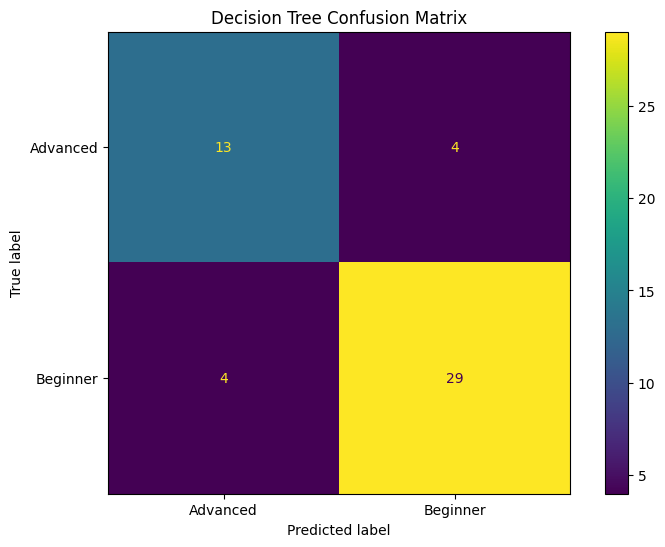

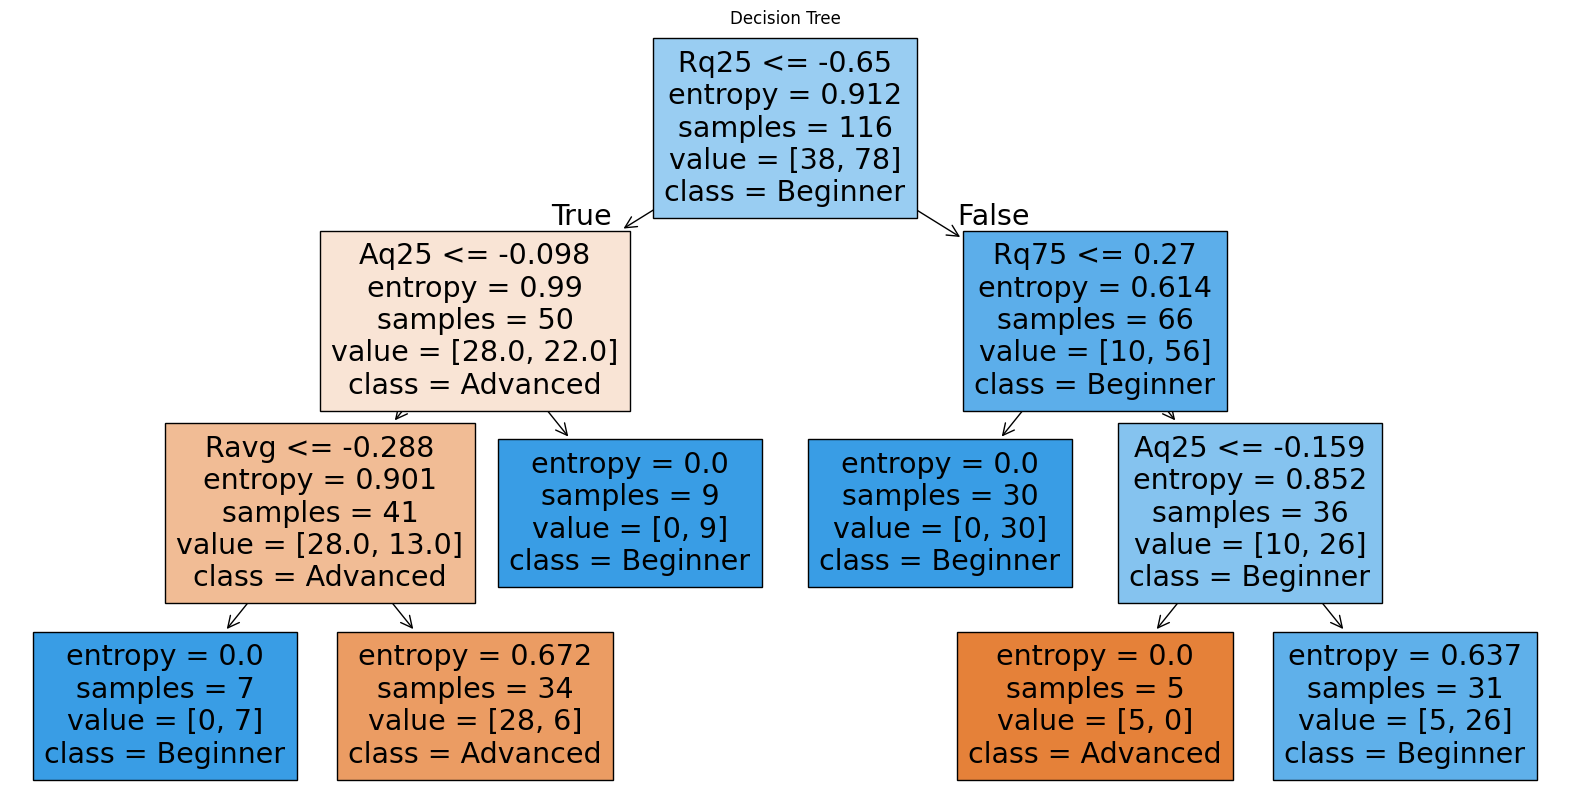

Top features:
    Feature      Score       P-Value
10    Rmin  49.179654  5.808323e-11
3     Amin  45.712462  2.289429e-10
4     Aq25  30.156375  1.492018e-07
11    Rq25  28.177776  3.549760e-07
13    Rstd  19.255596  2.039954e-05
2     Amed  11.400720  9.167678e-04
8     Rmax   5.952700  1.575991e-02
12    Rq75   5.730416  1.780254e-02
6     Astd   3.159489  7.734015e-02
0     Aavg   2.574026  1.105549e-01


In [38]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Load the combined data
feature_frames = pd.read_csv('./MyData/all_data3.csv')
feature_frames = feature_frames[feature_frames['activity'] != 'Test Set']

# Assuming you have a DataFrame `frames` and a value for `k`
frames = feature_frames  # or the appropriate DataFrame
k = 10  # or the appropriate value for k

# Call the train_decision_tree function
dt_model, dt_cm, acc, selected_features = train_decision_tree(frames, k)

# Evaluate the model
X = frames.drop(columns=['activity'])
y = frames['activity']
X_new, _, _ = select_top_k_features(X, y, k)
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_new, y, test_size=0.3, random_state=42)
y_pred_dt = dt_model.predict(X_test_dt)
print(classification_report(y_test_dt, y_pred_dt))
ConfusionMatrixDisplay.from_predictions(y_test_dt, y_pred_dt)
plt.title("Decision Tree Confusion Matrix")
plt.show()

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=selected_features, class_names=dt_model.classes_, filled=True)
plt.title("Decision Tree")
plt.show()
print("Top features:\n", top_features)

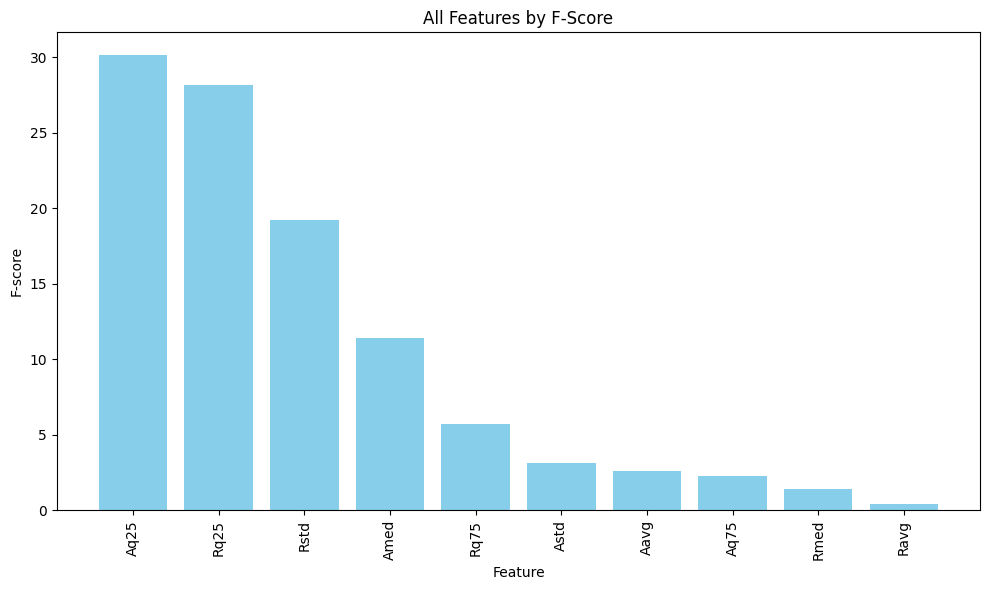

In [39]:
    X = frames.drop(columns=['activity'])
    y = frames['activity']
    X_new, selected_features, top_features = select_top_k_features(X, y, k)
    
    # Plot all features and their scores
    plt.figure(figsize=(10, 6))
    plt.bar(top_features['Feature'], top_features['Score'], color='skyblue')
    plt.title('All Features by F-Score')
    plt.xlabel('Feature')
    plt.ylabel('F-score')
    plt.xticks(rotation=90)  # Rotate feature names for better readability
    plt.tight_layout()
    plt.savefig('all_features_scores.png')
    plt.show()

In [84]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(frames, k):
    # Extract feature columns
    X = frames.drop(columns=['activity'])
    # Extract target column
    y = frames['activity']

    # Select top k features
    X_new, selected_features, top_features = select_top_k_features(X, y, k)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

    # Create model
    rf_model = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=4, random_state=42).fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)

    # Evaluate on test set
    acc = rf_model.score(X_test, y_test)
    rf_cm = confusion_matrix(y_test, rf_pred, labels=rf_model.classes_)
    print(classification_report(y_test, rf_pred))
    print("Accuracy on test set:", acc)

    # Display top features
    print("Top features:\n", top_features)

    return rf_model, rf_cm, acc, selected_features

              precision    recall  f1-score   support

    Advanced       0.80      0.71      0.75        17
    Beginner       0.86      0.91      0.88        33

    accuracy                           0.84        50
   macro avg       0.83      0.81      0.82        50
weighted avg       0.84      0.84      0.84        50

Accuracy on test set: 0.84
Top features:
    Feature      Score       P-Value
10    Rmin  49.179654  5.808323e-11
3     Amin  45.712462  2.289429e-10
4     Aq25  30.156375  1.492018e-07
11    Rq25  28.177776  3.549760e-07
13    Rstd  19.255596  2.039954e-05
2     Amed  11.400720  9.167678e-04
8     Rmax   5.952700  1.575991e-02
12    Rq75   5.730416  1.780254e-02
6     Astd   3.159489  7.734015e-02
0     Aavg   2.574026  1.105549e-01
Random Forest Classification Report:
              precision    recall  f1-score   support

    Advanced       0.80      0.71      0.75        17
    Beginner       0.86      0.91      0.88        33

    accuracy                      

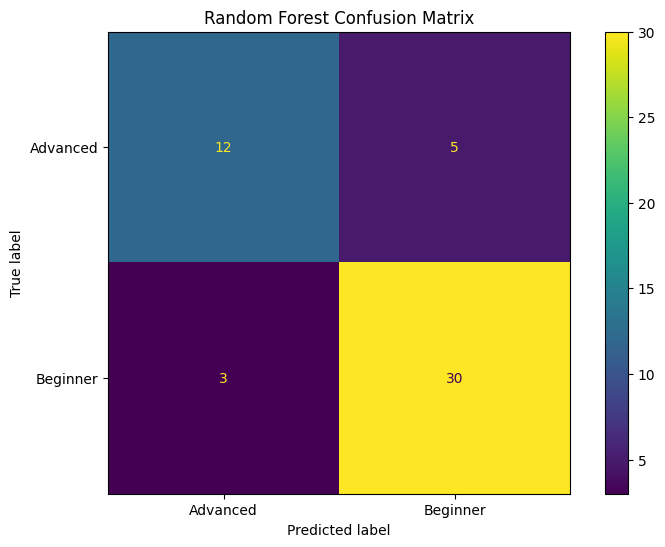

In [85]:
feature_frames = pd.read_csv('./MyData/all_data2.csv')
feature_frames = feature_frames[feature_frames['activity'] != 'Test Set']

frames = feature_frames
k = 10
rf_model, rf_cm, acc, selected_features = train_random_forest(frames, k)

X = frames.drop(columns=['activity'])
y = frames['activity']
X_new, _, _ = select_top_k_features(X, y, k)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_new, y, test_size=0.3, random_state=42)
y_pred_rf = rf_model.predict(X_test_rf)
print("Random Forest Classification Report:")
print(classification_report(y_test_rf, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_test_rf, y_pred_rf)
plt.title("Random Forest Confusion Matrix")
plt.show()

In [66]:
def visualize_signals(data):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(data['time'], data['filtered_accel_mag'], label='Filtered Acceleration Magnitude')
    plt.title('Acceleration Magnitude')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(data['time'], data['filtered_rotation_mag'], label='Filtered Rotation Magnitude')
    plt.title('Rotation Magnitude')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [67]:
def visualize_peaks(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data['time'], data['filtered_accel_mag'], label='Filtered Acceleration Magnitude')
    plt.plot(data['time'], data['peaks'], 'x', label='Peaks', color='red')
    plt.title('Acceleration Magnitude with Peaks')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.tight_layout()
    plt.show()

Combines all the data into a all_data.csv file

In [30]:

def all_data_to_combined_csv(root, output_filename='all_data3.csv'):
    all_data = pd.DataFrame()

    activity_category = os.listdir(root)
    print(f"Activity folders found: {activity_category}")

    for folder in activity_category:
        folder_path = os.path.join(root, folder)
        if os.path.isdir(folder_path):
            files = glob.glob(os.path.join(folder_path, '**', '*.csv'), recursive=True)
            print(f"Processing folder: {folder}, folder path: {folder_path}, files found: {files}")

            for filename in files:
                if os.path.basename(filename) == output_filename or 'Annotation' in filename or 'Metadata' in filename:
                    continue  # Skip the output file and irrelevant files

                data = pd.read_csv(filename)
                print(f"Reading file: {filename}, data shape: {data.shape}")
                print(f"Columns in file: {data.columns.tolist()}")

                try:
                    data = calc_magnitude(data)
                    data = rotation_magnitude(data)
                    data = remove_noise_rotation(data, sampling_rate=50)
                    data = remove_noise(data, sampling_rate=50)
                except KeyError as e:
                    print(f"Skipping file {filename} due to missing columns: {e}")
                    continue

                activity = os.path.basename(os.path.dirname(os.path.dirname(filename)))
                features = extract_features_sliding_window(data, window_sec=3, step_sec=1, sample_rate=50, activity=activity)
                print(f"Extracted features shape: {features.shape}")

                all_data = pd.concat([all_data, features], ignore_index=True)

    all_data.to_csv(os.path.join(root, output_filename), index=False)
    print(f"All data written to {output_filename}, total shape: {all_data.shape}")



In [34]:
# Combine all the data under data/Activities
all_data_to_combined_csv(root='./Mydata', output_filename='all_data3.csv')

feature_frames = pd.read_csv('./MyData/all_data3.csv')

Activity folders found: ['Advanced', 'all_data.csv', 'all_data2.csv', 'all_data3.csv', 'Beginner', 'Test Set']
Processing folder: Advanced, folder path: ./Mydata\Advanced, files found: ['./Mydata\\Advanced\\jake_advamced_4-2024-12-03_01-26-05\\Headphone.csv', './Mydata\\Advanced\\jake_advanced_1-2024-12-03_01-21-49\\Headphone.csv', './Mydata\\Advanced\\jake_advanced_2-2024-12-03_01-24-01\\Headphone.csv', './Mydata\\Advanced\\jake_advanced_5-2024-12-03_01-27-15\\Headphone.csv', './Mydata\\Advanced\\jake_good_purple_1-2024-12-03_01-48-55\\Headphone.csv', './Mydata\\Advanced\\josh1-2024-12-09_23-40-26\\Annotation.csv', './Mydata\\Advanced\\josh1-2024-12-09_23-40-26\\Headphone.csv', './Mydata\\Advanced\\josh1-2024-12-09_23-40-26\\Metadata.csv', './Mydata\\Advanced\\josh2-2024-12-09_23-41-56\\Annotation.csv', './Mydata\\Advanced\\josh2-2024-12-09_23-41-56\\Headphone.csv', './Mydata\\Advanced\\josh2-2024-12-09_23-41-56\\Metadata.csv', './Mydata\\Advanced\\josh3-2024-12-09_23-43-26\\Annotatio

Visualizes the signals
Descision Tree based classifier and confusion matrix

Train and Compare Acceleration-Only vs Rotation-Only Models

Acceleration-only Classification Report:
              precision    recall  f1-score   support

    Advanced       0.67      0.59      0.62        17
    Beginner       0.80      0.85      0.82        33

    accuracy                           0.76        50
   macro avg       0.73      0.72      0.72        50
weighted avg       0.75      0.76      0.76        50



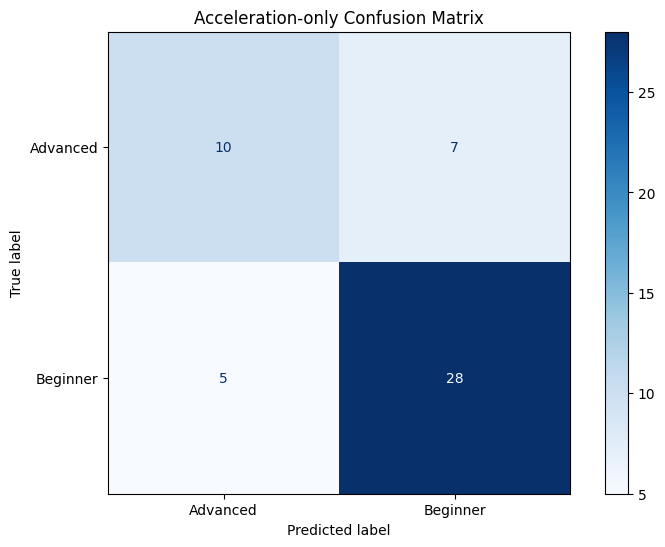

Rotation-only Classification Report:
              precision    recall  f1-score   support

    Advanced       0.71      0.88      0.79        17
    Beginner       0.93      0.82      0.87        33

    accuracy                           0.84        50
   macro avg       0.82      0.85      0.83        50
weighted avg       0.86      0.84      0.84        50



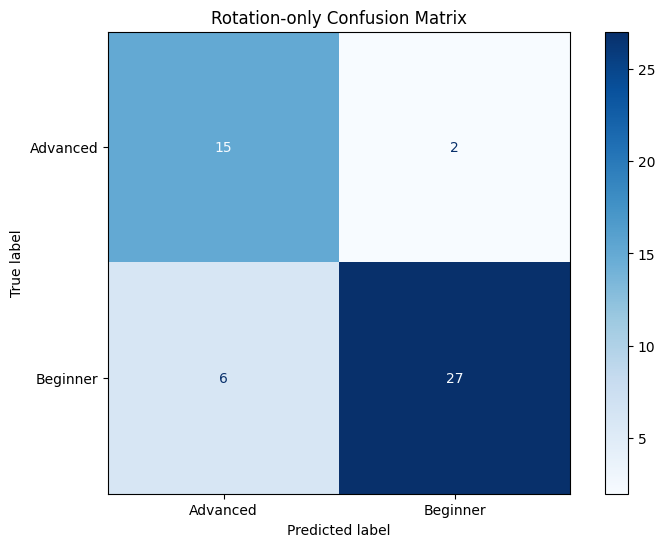

In [87]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define acceleration and rotation features
accel_features = ['Aavg', 'Amax', 'Amed', 'Amin', 'Aq25', 'Aq75', 'Astd']
rot_features = ['Ravg', 'Rmax', 'Rmed', 'Rmin', 'Rq25', 'Rq75', 'Rstd']

# Filter out the test set
feature_frames = feature_frames[feature_frames['activity'] != 'Test Set']

X_all = feature_frames.drop(columns=['activity'])
y_all = feature_frames['activity']

X_accel = X_all[accel_features]
X_rot = X_all[rot_features]

# Split data for acceleration-only
X_train_acc, X_test_acc, y_train_acc, y_test_acc = train_test_split(X_accel, y_all, test_size=0.3, random_state=42)
dt_accel = DecisionTreeClassifier(criterion='entropy', max_depth=4)
dt_accel.fit(X_train_acc, y_train_acc)
y_pred_acc = dt_accel.predict(X_test_acc)

print("Acceleration-only Classification Report:")
print(classification_report(y_test_acc, y_pred_acc))
disp_acc = ConfusionMatrixDisplay.from_predictions(y_test_acc, y_pred_acc, cmap='Blues')
plt.title("Acceleration-only Confusion Matrix")
plt.show()

# Split data for rotation-only
X_train_rot, X_test_rot, y_train_rot, y_test_rot = train_test_split(X_rot, y_all, test_size=0.3, random_state=42)
dt_rot = DecisionTreeClassifier(criterion='entropy', max_depth=3)
dt_rot.fit(X_train_rot, y_train_rot)
y_pred_rot = dt_rot.predict(X_test_rot)

print("Rotation-only Classification Report:")
print(classification_report(y_test_rot, y_pred_rot))
disp_rot = ConfusionMatrixDisplay.from_predictions(y_test_rot, y_pred_rot, cmap='Blues')
plt.title("Rotation-only Confusion Matrix")
plt.show()

Attempt at fall tracker - We might not need this - Josh

In [71]:
def detect_falls(data, accel_threshold=3.0):
    sample_rate = 50
    window_sec = 3
    step_sec = 1
    window_size = int(window_sec * sample_rate)
    step_size = int(step_sec * sample_rate)

    falls = []
    num_samples = len(data)
    for start in range(0, num_samples - window_size + 1, step_size):
        end = start + window_size
        window = data.iloc[start:end]
        if window['filtered_accel_mag'].max() > accel_threshold:
            falls.append((start, end))
    return falls

Filtered vs Unfiltered signals

In [36]:
def visualize_raw_vs_unfiltered(file_path, sample_rate = 50):
    raw_data = pd.read_csv(file_path)
    
    # Compute raw magnitudes
    raw_data['accel_mag_raw'] = np.sqrt(raw_data['accelerationX']**2 + raw_data['accelerationY']**2 + raw_data['accelerationZ']**2)
    raw_data['rotation_mag_raw'] = np.sqrt(raw_data['rotationRateX']**2 + raw_data['rotationRateY']**2 + raw_data['rotationRateZ']**2)

    # Processed data
    data = calc_magnitude(raw_data.copy())
    data = rotation_magnitude(data)
    data = remove_noise(data, sample_rate)
    data = remove_noise_rotation(data, sample_rate)

    plt.figure(figsize=(12, 6))

    # Raw vs Filtered Acceleration Magnitude
    plt.subplot(2, 1, 1)
    plt.plot(raw_data['time'], raw_data['accel_mag_raw'], label='Raw Acceleration Magnitude')
    plt.plot(data['time'], data['filtered_accel_mag'], label='Filtered Acceleration Magnitude')
    plt.title('Raw vs Filtered Acceleration Magnitude')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.legend()

    # Raw vs Filtered Rotation Magnitude
    plt.subplot(2, 1, 2)
    plt.plot(raw_data['time'], raw_data['rotation_mag_raw'], label='Raw Rotation Magnitude')
    plt.plot(data['time'], data['filtered_rotation_mag'], label='Filtered Rotation Magnitude')
    plt.title('Raw vs Filtered Rotation Magnitude')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.legend()

    plt.tight_layout()
    plt.show()

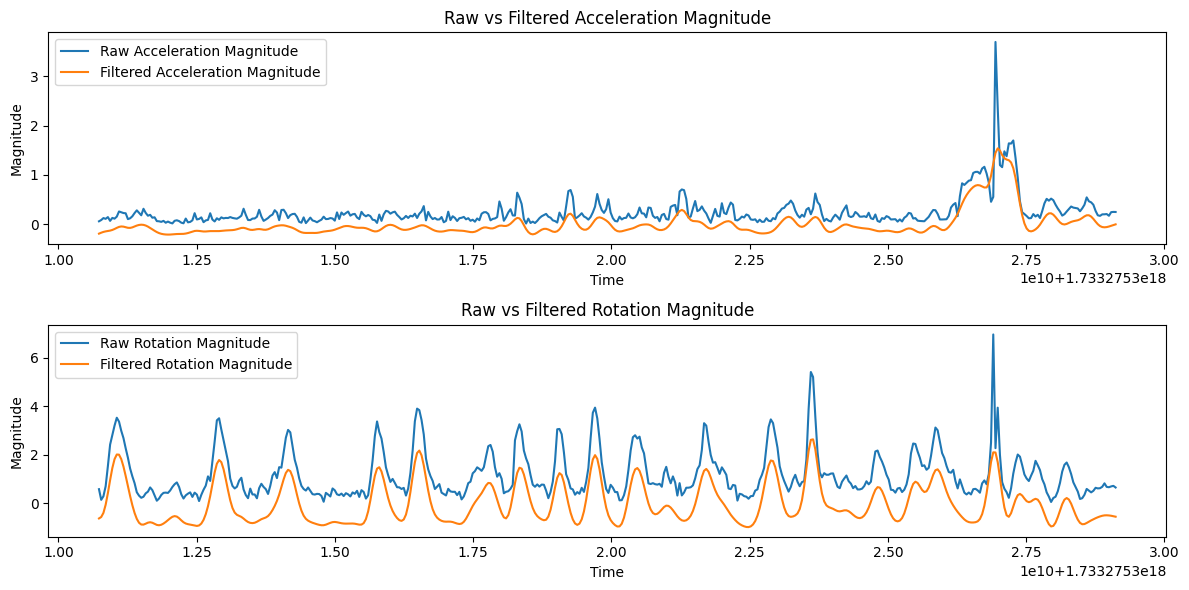

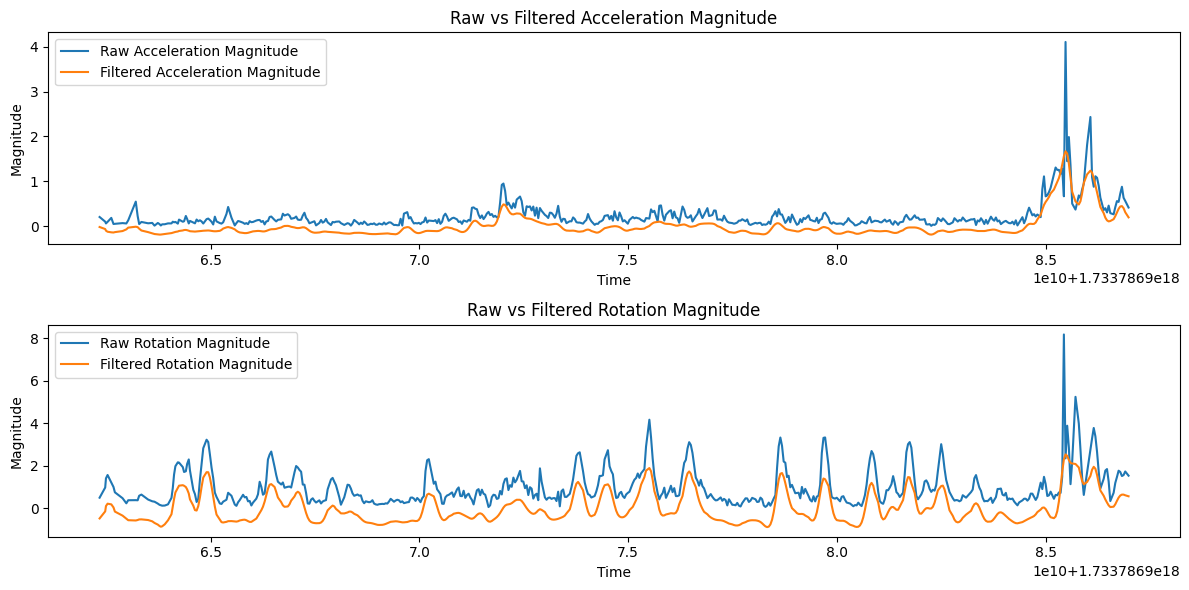

In [37]:
visualize_raw_vs_unfiltered('./MyData/Advanced/jake_advanced_1-2024-12-03_01-21-49/Headphone.csv')
visualize_raw_vs_unfiltered('./MyData/Beginner/julie1-2024-12-09_23-29-21/Headphone.csv')

#NOTES FOR 12/10/24
We want to determine if descision tree is better than random forest first
We want a clear chart of our confusion matrix + accuracy,f1,recall with: accel only, gyro only, then both
We want to see our top 4 functions for tree descisions visualized
Slides


In [74]:
def get_metrics(y_true, y_pred, model_name, feature_set):
    # Parse classification report
    report = classification_report(y_true, y_pred, output_dict=True)
    # We assume two classes: "Advanced" and "Beginner"
    # If you have more classes, adjust accordingly or summarize weighted avg
    accuracy = report['accuracy']
    advanced_f1 = report['Advanced']['f1-score']
    beginner_f1 = report['Beginner']['f1-score']
    macro_f1 = report['macro avg']['f1-score']  # macro average across classes
    weighted_f1 = report['weighted avg']['f1-score']
    
    return {
        'Model': model_name,
        'Feature Set': feature_set,
        'Accuracy': accuracy,
        'Macro F1': macro_f1,
        'Weighted F1': weighted_f1,
        'Advanced F1': advanced_f1,
        'Beginner F1': beginner_f1
    }


In [75]:
results = []


y_pred_acc = dt_accel.predict(X_test_acc)
results.append(get_metrics(y_test_acc, y_pred_acc, model_name="Decision Tree", feature_set="Acceleration-only"))


y_pred_rot = dt_rot.predict(X_test_rot)
results.append(get_metrics(y_test_rot, y_pred_rot, model_name="Decision Tree", feature_set="Rotation-only"))

# Combined (Decision Tree)
# You have y_pred and y_test from your combined DT scenario already:
# They were computed after running train_decision_tree(frames, k)
y_pred_combined_dt = y_pred_dt # reuse from your code, or re-run dt_model.predict(X_test)
results.append(get_metrics(y_test_dt, y_pred_combined_dt, model_name="Decision Tree", feature_set="Combined"))

# Combined (Random Forest)
# Similarly, after train_random_forest(frames, k) you computed y_pred_rf
y_pred_combined_rf = y_pred_rf
results.append(get_metrics(y_test_rf, y_pred_combined_rf, model_name="Random Forest", feature_set="Combined"))

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

           Model        Feature Set  Accuracy  Macro F1  Weighted F1  \
0  Decision Tree  Acceleration-only  0.686275  0.647059     0.686275   
1  Decision Tree      Rotation-only  0.745098  0.495786     0.775356   
2  Decision Tree           Combined  0.780000  0.732880     0.768781   
3  Random Forest           Combined  0.920000  0.910873     0.920000   

   Advanced F1  Beginner F1  
0     0.529412     0.764706  
1     0.648649     0.838710  
2     0.620690     0.845070  
3     0.882353     0.939394  


C:\Users\Joshua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Joshua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Joshua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: U

Random Forest may be preferable

In [76]:
# accel only random forest
X_train_acc_rf, X_test_acc_rf, y_train_acc_rf, y_test_acc_rf = train_test_split(X_accel, y_all, test_size=0.3, random_state=42)
rf_accel = RandomForestClassifier(n_estimators = 100, criterion='entropy', max_depth=10, random_state=42)
rf_accel.fit(X_train_acc_rf, y_train_acc_rf)
y_pred_acc_rf = rf_accel.predict(X_test_acc_rf)

results.append(get_metrics(y_test_acc_rf, y_pred_acc_rf, model_name='Random Forest', feature_set='Acceleration-only'))

# rotation only random forest
X_train_rot_rf, X_test_rot_rf, y_train_rot_rf, y_test_rot_rf = train_test_split(X_rot, y_all, test_size=0.3, random_state=42)
rf_rot = RandomForestClassifier(n_estimators = 100, criterion='entropy', max_depth=10, random_state=42)
rf_rot.fit(X_train_rot_rf, y_train_rot_rf)
y_pred_rot_rf = rf_rot.predict(X_test_rot_rf)

results.append(get_metrics(y_test_rot_rf, y_pred_rot_rf, model_name='Random Forest', feature_set='Rotation-only'))

results_df = pd.DataFrame(results)
print(results_df)

           Model        Feature Set  Accuracy  Macro F1  Weighted F1  \
0  Decision Tree  Acceleration-only  0.686275  0.647059     0.686275   
1  Decision Tree      Rotation-only  0.745098  0.495786     0.775356   
2  Decision Tree           Combined  0.780000  0.732880     0.768781   
3  Random Forest           Combined  0.920000  0.910873     0.920000   
4  Random Forest  Acceleration-only  0.764706  0.481690     0.763380   
5  Random Forest      Rotation-only  0.803922  0.794355     0.809140   

   Advanced F1  Beginner F1  
0     0.529412     0.764706  
1     0.648649     0.838710  
2     0.620690     0.845070  
3     0.882353     0.939394  
4     0.600000     0.845070  
5     0.750000     0.838710  


C:\Users\Joshua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Joshua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Joshua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: U

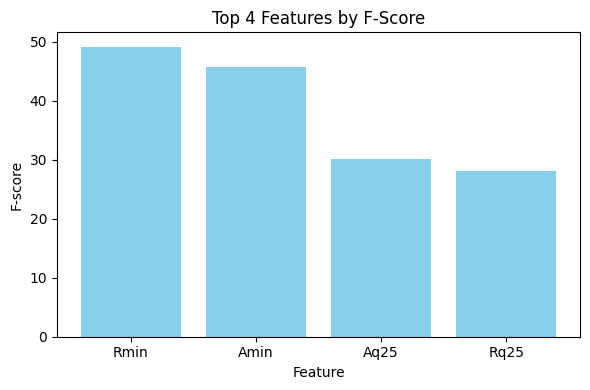

In [77]:
X = frames.drop(columns=['activity'])
y = frames['activity']
X_new, selected_features, top_features = select_top_k_features(X, y, k)

top_4 = top_features.head(4)

plt.figure(figsize=(6,4))
plt.bar(top_4['Feature'], top_4['Score'], color='skyblue')
plt.title('Top 4 Features by F-Score')
plt.xlabel('Feature')
plt.ylabel('F-score')
plt.tight_layout()
plt.show()